In [1]:
# Import necessary libraries
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

### First CNN model

In [2]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        # Define the convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 512),  # Adjust input size based on the output size of conv layers
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layers
        x = self.fc_layers(x)  # Apply fully connected layers
        return x

# Specify the number of classes
num_classes = 5  # Adjust based on dataset

# Instantiate the model
model = SimpleCNN(num_classes=num_classes)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("Simple CNN model defined and moved to device.")

Simple CNN model defined and moved to device.


In [3]:
# Define data augmentation and preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to range [-1, 1]
])

# Prepare dataset
spectrogram_base_path_train = r'C:\Users\user\Desktop\birdclef-2022\spectrograms_train'

# Using ImageFolder since the dataset is structured with subdirectories for each class 
train_dataset = datasets.ImageFolder(spectrogram_base_path_train, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

print("DataLoaders for CNN (train and validation) are ready.")

DataLoaders for CNN (train and validation) are ready.


In [4]:
# Define path to test spectrograms
spectrogram_base_path_test = r'C:\Users\user\Desktop\birdclef-2022\spectrograms_test'

# Create the test dataset
test_dataset = datasets.ImageFolder(spectrogram_base_path_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("DataLoader for test data is ready.")

DataLoader for test data is ready.


In [5]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with a learning rate of 0.001

print("Loss function and optimizer are defined.")

Loss function and optimizer are defined.


Epoch [1/10], Train Loss: 1.8850, Val Loss: 1.3403
Epoch [2/10], Train Loss: 1.2785, Val Loss: 1.0561
Epoch [3/10], Train Loss: 0.8878, Val Loss: 0.8067
Epoch [4/10], Train Loss: 0.6407, Val Loss: 0.6364
Epoch [5/10], Train Loss: 0.4889, Val Loss: 0.5196
Epoch [6/10], Train Loss: 0.3360, Val Loss: 0.4907
Epoch [7/10], Train Loss: 0.2760, Val Loss: 0.5245
Epoch [8/10], Train Loss: 0.2524, Val Loss: 0.4394
Epoch [9/10], Train Loss: 0.1997, Val Loss: 0.5481
Epoch [10/10], Train Loss: 0.1640, Val Loss: 0.5747
Model training complete. Best model saved as best_cnn_model.pth.


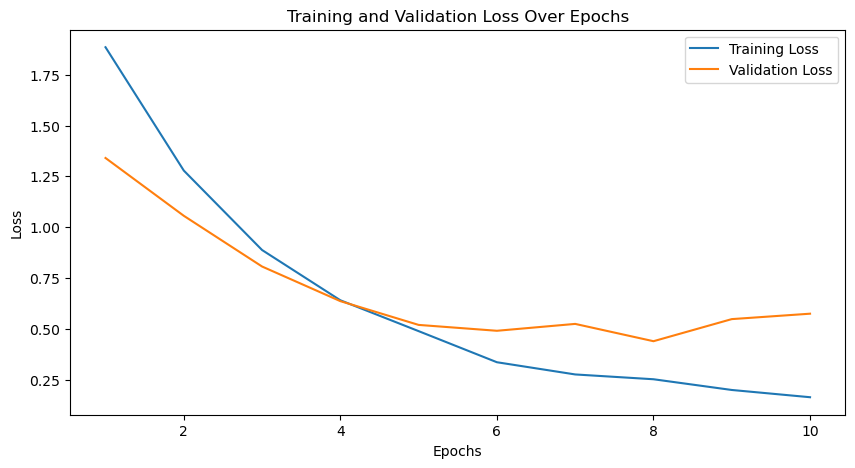

In [6]:
# Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Initialize variables to keep track of the best validation loss
best_val_loss = float('inf')  # Set initial best validation loss to infinity

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize the running loss for the current epoch
    
    # Iterate over the training data
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the GPU if available

        optimizer.zero_grad()  # Reset gradients to zero
        outputs = model(inputs)  # Forward pass: compute model outputs
        loss = criterion(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate loss for monitoring

    # Calculate the average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Save training loss for plotting
    
    # Evaluate the model on the validation data
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Calculate the average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)  # Save validation loss for plotting

    # Print training and validation loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the best model based on validation loss
    if avg_val_loss < best_val_loss:  # If the current validation loss is lower than the best observed so far
        best_val_loss = avg_val_loss  # Update the best validation loss
        torch.save(model.state_dict(), 'best_cnn_model.pth')  # Save the best model

print("Model training complete. Best model saved as best_cnn_model.pth.")

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [7]:
# Load the best saved model
model.load_state_dict(torch.load('best_cnn_model.pth'))
model.eval()  # Set the model to evaluation mode

# Initialize lists to collect predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8742
Precision: 0.8763
Recall: 0.8742
F1 Score: 0.8728


<Figure size 1000x800 with 0 Axes>

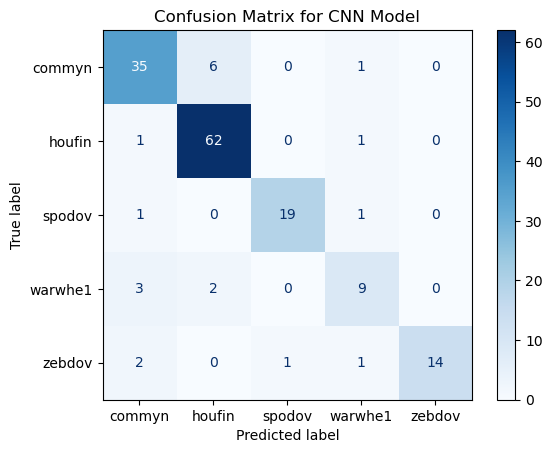

In [8]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for CNN Model')
plt.show()

### Improved model CNN model

In [9]:
# Enhanced data augmentation and preprocessing transformations
improved_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip spectrograms horizontally
    transforms.RandomRotation(15),  # Randomly rotate spectrograms
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),  # Random affine transformations
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to range [-1, 1]
])

# Create new dataset with improved augmentation
train_dataset = datasets.ImageFolder(spectrogram_base_path_train, transform=improved_transform)

# Same data splitting as before
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [10]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        # Define the convolutional layers with Batch Normalization
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the fully connected layers with more complexity
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 28 * 28, 1024),  # Increase the number of neurons
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased dropout
            nn.Linear(1024, 512),  # Add one more FC layer
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Final output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc_layers(x)  # Apply fully connected layers
        return x

    
# Specify the number of classes
num_classes = 5  # Adjust based on your dataset

# Instantiate the improved model
improved_model = ImprovedCNN(num_classes=num_classes)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
improved_model.to(device)

print("Improved CNN model defined and moved to device.")


Improved CNN model defined and moved to device.


In [11]:
# Define loss function and optimizer with L2 regularization
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(improved_model.parameters(), lr=0.0005, weight_decay=1e-4)  # Adjusted learning rate and added L2 regularization
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)  # Learning rate scheduler

print("Loss function, optimizer, and learning rate scheduler are defined.")

Loss function, optimizer, and learning rate scheduler are defined.


Epoch [1/50], Train Loss: 10.1966, Val Loss: 2.0679
Epoch [2/50], Train Loss: 2.9331, Val Loss: 1.6847
Epoch [3/50], Train Loss: 1.7088, Val Loss: 1.2096
Epoch [4/50], Train Loss: 1.2014, Val Loss: 0.8169
Epoch [5/50], Train Loss: 0.6706, Val Loss: 0.6278
Epoch [6/50], Train Loss: 0.5427, Val Loss: 0.4733
Epoch [7/50], Train Loss: 0.4861, Val Loss: 0.4417
Epoch [8/50], Train Loss: 0.4196, Val Loss: 0.4029
Epoch [9/50], Train Loss: 0.3568, Val Loss: 0.4008
Epoch [10/50], Train Loss: 0.3677, Val Loss: 0.5083
Epoch [11/50], Train Loss: 0.3285, Val Loss: 0.4004
Epoch [12/50], Train Loss: 0.3083, Val Loss: 0.4788
Epoch [13/50], Train Loss: 0.2625, Val Loss: 0.4530
Epoch [14/50], Train Loss: 0.2194, Val Loss: 0.4477
Epoch [15/50], Train Loss: 0.2355, Val Loss: 0.4112
Epoch [16/50], Train Loss: 0.1658, Val Loss: 0.4218
Early stopping triggered
Improved model training complete. Best model saved as best_improved_cnn_model.pth.


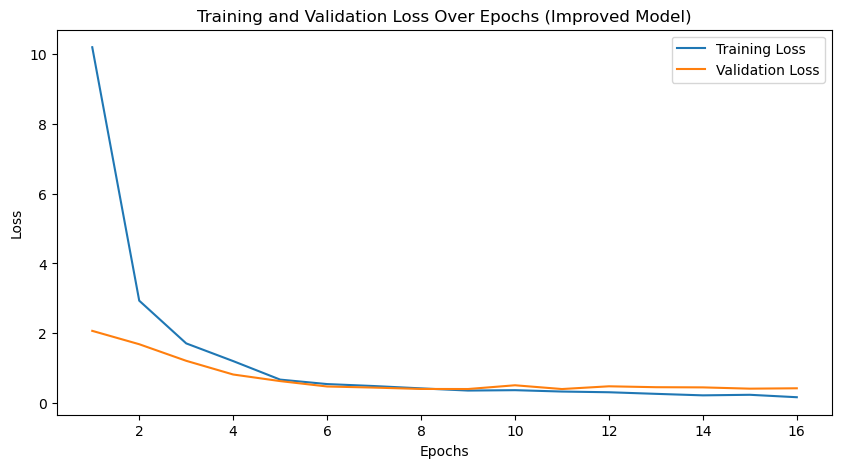

In [12]:
# Initialize variables for early stopping
best_val_loss = float('inf')
patience = 5
counter = 0

# Lists to store loss values for plotting
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    improved_model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = improved_model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on validation data
    improved_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = improved_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(improved_model.state_dict(), 'best_improved_cnn_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

print("Improved model training complete. Best model saved as best_improved_cnn_model.pth.")

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Improved Model)')
plt.legend()
plt.show()

In [13]:
# Load the best saved improved model
improved_model.load_state_dict(torch.load('best_improved_cnn_model.pth'))
improved_model.eval()  # Set the model to evaluation mode

# Initialize lists to collect predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = improved_model(inputs)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability

        all_preds.extend(preds.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8931
Precision: 0.8940
Recall: 0.8931
F1 Score: 0.8899


<Figure size 1000x800 with 0 Axes>

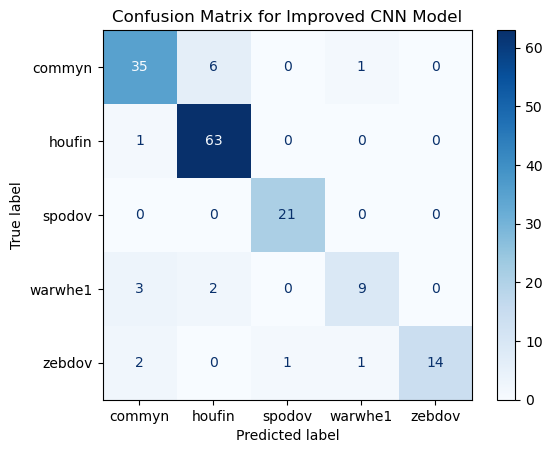

In [14]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for Improved CNN Model')
plt.show()